In [1]:
import warnings;
warnings.simplefilter('ignore')

In [6]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import os; os.chdir('../')

import pandas as pd
import numpy as np

from scripts import datasources
from scripts import models
from scripts import variables

In [7]:
# mm.initialize()

## Generating accesibility variables

In [8]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables


FileNotFoundError: [Errno 2] No such file or directory: './configs/network_aggregations_small.yaml'

In [ ]:
orca.run(['initialize_network_walk', 'network_aggregations_walk'])

## Loading data

In [4]:
#Loading am peak transit accessibility varaibles
@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodessmall.index.name = 'node_id_small'
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodeswalk.index.name = 'node_id_walk'
am_acc = orca.get_table('am_acc').to_frame()

KeyError: 'netsmall'

In [ ]:
#Generating boradcastings
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'nodessmall', onto = 'households', cast_index = True, onto_on = 'node_id_small')
orca.broadcast(cast = 'nodeswalk', onto = 'households', cast_index = True, onto_on = 'node_id_walk')
# Parcel onto building onto units onto Households is predefined

#Merging tables
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'])
    return df

In [ ]:
orca.get_table('households').to_frame().head(5)

In [ ]:
hh_merged = orca.get_table('hh_merged').to_frame()

In [16]:
hh_merged = orca.get_table('hh_merged').to_frame()
#Generating household variables from the persons table 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

# Merging variables to hh_merge
hh_merged = hh_merged .merge(hh_16_younger, on = 'household_id', how = 'left'
                           ).merge(hh_70_older, on ='household_id', how = 'left'
                                  ).merge(hh_students, on= 'household_id',how = 'left'
                                         ).merge(hh_work_home, on= 'household_id', how = 'left')

In [ ]:
households.shape

In [ ]:
hh_merged.shape

In [23]:
list(set(am_acc.columns))
hh_merged.loc[:,list(set(am_acc.columns))].isnull().sum()
hh_merged.shape

(2335, 203)

In [ ]:
#Impute missing infomration in the parcel/trasint accessibility table (Fill NA with median value)
for acc_col in set(am_acc.columns):
    hh_merge[acc_col].fillna(hh_merge[acc_col].median())
#     orca.add_column('parcels',acc_col,
#          parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())

In [94]:
df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
df.columns

Index(['osmid', 'units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000',
       'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000',
       'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000',
       'pop_asian_10000', 'pop_hisp_10000', 'units_25000', 'units_sf_25000',
       'units_mf_25000', 'pop_25000', 'hh_25000', 'poor_25000',
       'renters_25000', 'med_income_25000', 'jobs_25000', 'med_rent_25000',
       'pop_white_25000', 'pop_black_25000', 'pop_asian_25000',
       'pop_hisp_25000'],
      dtype='object')

In [4]:
#initialization only
orca.run(['initialize_network_small','initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [37]:
households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
jobs = orca.get_table('jobs').to_frame()

In [15]:
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

In [11]:
persons.columns

Index(['member_id', 'age', 'primary_commute_mode', 'relate', 'edu', 'sex',
       'hours', 'hispanic', 'earning', 'race_id', 'student', 'work_at_home',
       'worker', 'household_id', 'node_id_small', 'node_id_walk',
       'no_higher_ed', 'age_under_45', 'zone_id_home', 'lessGED', 'GED',
       'somebach', 'Assoc', 'Bach', 'female', 'white', 'minority',
       'age_16less25'],
      dtype='object')

In [40]:
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})


In [43]:
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_3,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,0,1,1,0,0,1,1,1,1
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,0,1,1,3,2


In [47]:
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [48]:
hh_merge.head(5)

,serialno,persons,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,state,...,tenure_4,single_family_int,building_type_2,hh_inc_150kplus,hh_size_1per,hh_16_younger,hh_70_older,hh_student,hh_work_home,cars_alt
household_id,,,,,,,,,,,,,,,,,,,,,
14127,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
17257,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
24020,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
28196,2009001190619,3.0,2.0,2.0,66600.0,1,yes,76,2.0,6,...,0,1,1,0,0,1,1,1,1,2
33517,2013000084437,5.0,8.0,3.0,75700.0,1,no,71,4.0,6,...,0,0,0,0,0,1,1,3,2,3


In [22]:
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)

In [23]:
# # income bins
# income_bins = pd.cut(orca.get_table('households').to_frame().income,
#       bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
#       labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
# income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
# for i in income_bin_dummies.columns:
#     orca.add_column('households',i,income_bin_dummies[i])

# # tenure type dummy
# orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
# orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
# orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
# orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# # single family as integer
# orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# # building type dummy
# orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [56]:
parcels = orca.get_table('parcels').to_frame()

In [70]:
os.listdir("/home/data/urbanaccess_transit")

['access_indicators_latenight.csv',
 'access_indicators_pmpeak.csv',
 'access_indicators_noon.csv',
 'access_indicators_ampeak.csv']

In [57]:
# load UrbanAccess transit accessibility variables
am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
am_acc.block_id = am_acc.block_id.str.zfill(15)
parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index) # reorder to align with parcels table

In [77]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk'],
      dtype='object')

In [72]:
am_acc.columns

Index(['block_id', 'above_jobs_20', 'above_jobs_40', 'above_jobs_60',
       'average_income_20', 'below_jobs_20', 'below_jobs_40', 'below_jobs_60',
       'employment_20', 'employment_40', 'employment_60', 'population_20',
       'population_40', 'population_60'],
      dtype='object')

In [58]:
parcels_with_acc.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'above_jobs_20',
       'above_jobs_40', 'above_jobs_60', 'average_income_20', 'below_jobs_20',
       'below_jobs_40', 'below_jobs_60', 'employment_20', 'employment_40',
       'employment_60', 'population_20', 'population_40', 'population_60'],
      dtype='object')

In [80]:
parcels_with_acc.shape

(1956207, 31)

In [81]:
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [91]:
nodessmall = orca.get_table('nodessmall').to_frame()
nodessmall.columns

Index(['units_10000', 'units_sf_10000', 'units_mf_10000', 'pop_10000',
       'hh_10000', 'poor_10000', 'renters_10000', 'med_income_10000',
       'jobs_10000', 'med_rent_10000', 'pop_white_10000', 'pop_black_10000',
       'pop_asian_10000', 'pop_hisp_10000', 'units_25000', 'units_sf_25000',
       'units_mf_25000', 'pop_25000', 'hh_25000', 'poor_25000',
       'renters_25000', 'med_income_25000', 'jobs_25000', 'med_rent_25000',
       'pop_white_25000', 'pop_black_25000', 'pop_asian_25000',
       'pop_hisp_25000'],
      dtype='object')

In [96]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodeswalk.columns

Index(['units_500_walk', 'sqft_unit_500_walk', 'singles_500_walk',
       'elderly_hh_500_walk', 'children_500_walk', 'units_sf_500_walk',
       'units_mf_500_walk', 'pop_500_walk', 'hh_500_walk', 'poor_500_walk',
       'rich_500_walk', 'renters_500_walk', 'avg_income_500_walk',
       'jobs_500_walk', 'avg_rent_500_walk', 'pop_white_500_walk',
       'pop_black_500_walk', 'pop_asian_500_walk', 'pop_hisp_500_walk',
       'units_1500_walk', 'sqft_unit_1500_walk', 'singles_1500_walk',
       'elderly_hh_1500_walk', 'children_1500_walk', 'units_sf_1500_walk',
       'units_mf_1500_walk', 'pop_1500_walk', 'hh_1500_walk', 'poor_1500_walk',
       'rich_1500_walk', 'renters_1500_walk', 'avg_income_1500_walk',
       'jobs_1500_walk', 'avg_rent_1500_walk', 'pop_white_1500_walk',
       'pop_black_1500_walk', 'pop_asian_1500_walk', 'pop_hisp_1500_walk',
       'pop_2500_walk', 'pop_white_2500_walk', 'pop_black_2500_walk',
       'pop_asian_2500_walk', 'pop_hisp_2500_walk', 'prop_children_50

In [84]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [97]:
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [99]:


acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns) + list(set(parcels_with_acc.columns) - set(parcels))

df = orca.get_table('hh_merged').to_frame()
df.shape

(2487699, 185)

In [ ]:
#Exclude
'serialno', 'cars',  'tract', 'block_group'

#Binary Choices
'hispanic_head','recent_mover', 'single_family'

#Continous
'building_type', 'income', 'race_of_head', 'age_of_head', 'workers','county', 'children', 'tenure',

In [108]:
df['cars_alt'] = df['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

In [112]:
df.columns[:100] 

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per', 'num_units', 'unit_num', 'unit_residential_price',
       'unit_residential_rent', 'parcel_id', 'development_type_id',
       'improvement_value', 'residential_units', 'residential_sqft',
       'sqft_per_unit', 'non_residential_sqft', 'building_sqft',
       'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built',
       'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type',
       'costar_property_type', 'costar_rent', 'building_type_id',
   

In [14]:
#Defining a set of Variables for the model 


In [15]:
X = df.drop(labels = 'cars_alt', axis =1)
y = df['cars_alt']

In [ ]:
# sample_size = 100000
# df_data_jayne = df.sample(n= sample_size, random_state= 234)
# x = df_data_jayne.drop(labels = 'cars_alt', axis =1)
# y = df_data_jayne['cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)
    
# result_train = []
# result_test = []
# max_depth = range(1,30)
# for i in max_depth:
#     clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
#     scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
#     result_train.append(scores['train_score'].mean())
#     result_test.append(scores['test_score'].mean()) 
     
# plt.figure()
# plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
# plt.plot(max_depth, result_test, '-o',color='red',label='Test')
# plt.xlabel('Max depth')
# plt.ylabel('Accuracy')
# plt.title('Random sample =' + str(sample_size))
# plt.legend()

In [ ]:
# clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=8)
# clf.fit(X_train, y_train)

# aa = pd.DataFrame({'importances':clf.feature_importances_,
#                    'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

# aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue', figsize =(5,15) )
# plt.yticks()#(fontsize = 10)
# plt.tight_layout()

In [243]:
# print (clf.score(X_test, y_test))
# pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

0.6116060606060606


col_0,0,1,2,3
cars_alt,,,,
0,0.386697,0.500188,0.090943,0.022172
1,0.053884,0.683865,0.224602,0.037649
2,0.009274,0.196963,0.666968,0.126795
3,0.004067,0.068893,0.414222,0.512817


In [59]:
df_a = pd.DataFrame(
    {'a': [0, 1]},
    index=['a0', 'a1'])
df_b = pd.DataFrame(
    {'b': [2, 3, 4, 5, 6],
     'a_id': ['a0', 'a1', 'a1', 'a0', 'a1']},
    index=['b0', 'b1', 'b2', 'b3', 'b4'])
df_c = pd.DataFrame(
    {'c': [7, 8, 9]},
    index=['c0', 'c1', 'c2'])
df_d = pd.DataFrame(
    {'d': [10, 11, 12, 13, 15, 16, 16, 17, 18, 19],
     'b_id': ['b2', 'b0', 'b3', 'b3', 'b1', 'b4', 'b1', 'b4', 'b3', 'b3'],
     'c_id': ['c0', 'c1', 'c1', 'c0', 'c0', 'c2', 'c1', 'c2', 'c1', 'c2']},
    index=['d0', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9'])

orca.add_table('a', df_a)
orca.add_table('b', df_b)
orca.add_table('c', df_c)
orca.add_table('d', df_d)

In [60]:
orca.broadcast(cast='a', onto='b', cast_index=True, onto_on='a_id')
orca.broadcast(cast='b', onto='d', cast_index=True, onto_on='b_id')
orca.broadcast(cast='c', onto='d', cast_index=True, onto_on='c_id')

# Data 

## Reading & Merging data 

In [122]:
@orca.table(cache=False)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    df.rename(columns = {'osmid':'node_id_small'}, inplace = True)
    df.set_index('node_id_small',inplace = True)
    return df

@orca.table(cache=False)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    df.rename(columns = {'osmid':'node_id_walk'}, inplace = True)
    df.set_index('node_id_walk',inplace = True)
    return df

@orca.table(cache=False)
def am_acc():
    df = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
    df.block_id = df.block_id.str.zfill(15)
    return df

households = orca.get_table('households').to_frame()
persons = orca.get_table('persons').to_frame()
parcels = orca.get_table('parcels').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
nodeswalk = orca.get_table('nodeswalk').to_frame()
am_acc = orca.get_table('am_acc').to_frame()

# # load UrbanAccess transit accessibility variables
# am_acc = pd.read_csv('/home/data/urbanaccess_transit/access_indicators_ampeak.csv',dtype = {'block_id':str})
# am_acc.block_id = am_acc.block_id.str.zfill(15)
# parcels_with_acc = parcels.merge(am_acc, how='left', on='block_id').reindex(index = parcels.index)

# #Creating a county dummy 
# county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
# for i in county_dummies.columns:
#     orca.add_column('parcels',i,county_dummies[i])

In [148]:
# persons.columns
households.columns

Index(['serialno', 'persons', 'building_type', 'cars', 'income',
       'race_of_head', 'hispanic_head', 'age_of_head', 'workers', 'state',
       'county', 'tract', 'block_group', 'children', 'tenure', 'recent_mover',
       'block_group_id', 'single_family', 'unit_id', 'building_id',
       'node_id_small', 'node_id_walk', 'hh_inc_under_25k', 'hh_inc_25_to_75k',
       'hh_inc_75_to_200k', 'tenure_1', 'tenure_2', 'tenure_3', 'tenure_4',
       'single_family_int', 'building_type_2', 'hh_inc_150kplus',
       'hh_size_1per'],
      dtype='object')

In [149]:
parcels.columns

Index(['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id',
       'proportion_undevelopable', 'tax_exempt_status', 'apn',
       'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area',
       'block_id', 'node_id', 'node_id_small', 'node_id_walk', 'population_60',
       'below_jobs_20', 'below_jobs_60', 'below_jobs_40', 'employment_20',
       'above_jobs_40', 'average_income_20', 'population_20', 'employment_40',
       'population_40', 'employment_60', 'above_jobs_60', 'above_jobs_20',
       'county_1', 'county_13', 'county_41', 'county_55', 'county_75',
       'county_81', 'county_85', 'county_95', 'county_97'],
      dtype='object')

In [146]:
#Broadcasting tables 
orca.broadcast(cast = 'am_acc', onto = 'parcels', cast_on = 'block_id', onto_on = 'block_id')
orca.broadcast(cast = 'persons', onto = 'households', cast_on ='household_id', onto_index = True)

In [150]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('buildings', 'establishments'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels'),
 ('a', 'b'),
 ('b', 'd'),
 ('c', 'd'),
 ('persons', 'households'),
 ('am_acc', 'parcels')]

In [ ]:
# More household varibles from the persons table. 
hh_16_younger = persons[persons['age'] < 16].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_16_younger'})
hh_70_older = persons[persons['age'] > 70].groupby(by='household_id').agg({'age':'count'}).rename(columns={'age': 'hh_70_older'})
hh_students = persons[persons['student'] == 1].groupby(by='household_id').agg({'student':'count'}).rename(columns={'student': 'hh_student'})
hh_work_home = persons[persons['work_at_home'] == 1].groupby(by='household_id').agg({'work_at_home':'count'}).rename(columns={'work_at_home': 'hh_work_home'})

#Mergin new varaibles to the household table 
## CHANGE THIS TO ORCA PIPELINE FLOW
hh_merge = households.merge(hh_16_younger, on = 'household_id',
                           ).merge(hh_70_older, on ='household_id',
                                  ).merge(hh_students, on= 'household_id',
                                         ).merge(hh_work_home, on= 'household_id' )

hh_merge.head(5)

#Example of how to use ORCA flow
# cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
# orca.add_column('households', 'cars_alt', cars_alt)


#Creating the dependent variables 0, 1 ,2 or +3 cars 
hh_merge['cars_alt'] = hh_merge['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))

#Impute missing infomration in the parcel/trasint accessibility table 
for acc_col in set(parcels_with_acc.columns) - set(parcels):
    # fill NA with median value
    orca.add_column('parcels',acc_col,
         parcels_with_acc[acc_col].fillna(parcels_with_acc[acc_col].median())
                   )

In [ ]:
#Merging 
@orca.table(cache=False)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels'
                                                          ,'nodessmall','nodeswalk'
                                                          ])
    return df

In [ ]:
#Final Data set 
df = orca.get_table('hh_merged').to_frame()

## Data cleaning

In [96]:
#Importing data 
df = orca.get_table('households').to_frame()
df_data = df.loc[:,['serialno','persons', 'income','race_of_head','age_of_head', 
                    'workers','children', 'tenure','cars_alt']]

In [97]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['income', 'age_of_head', 'workers', 'children', 'tenure' ]

for i in to_normalize:
    df_data[i] = normalize(df_data[[i]])

In [98]:
#Training and test index
import random
index_list = df_data.serialno.unique()

train_index = np.array(random.sample(list(index_list), int(len(index_list)*0.66) ))
test_index = index_list[~np.isin(index_list, train)]

#Training and test set 
X_train = df_data[df_data.serialno.isin(train_index)].drop(['serialno', 'cars_alt'], axis=1)
y_train = df_data[df_data.serialno.isin(train_index)].loc[:,['cars_alt']]

X_test = df_data[df_data.serialno.isin(test_index)].drop(['serialno', 'cars_alt'], axis=1)
y_test = df_data[df_data.serialno.isin(test_index)].loc[:,['cars_alt']]

In [95]:
# df_data = df.loc[:,['persons', 'income','race_of_head', 'age_of_head', 
#                     'workers','children', 'tenure', 'recent_mover',
#                     'sqft_per_unit', 'res_price_per_sqft',
#                     'land_value', 'county_id', 'zone_id','tax_exempt_status',
#                     'development_type_id', 'cars_alt' ]]

# Machine Learning Approach 

## Decision Tree

In [100]:
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate

In [113]:
# #Splitting the data
# x = df_data.drop('cars_alt', axis = 1)
# y = df_data.loc[:,'cars_alt']
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

In [101]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
scores

{'fit_time': array([4.05221915, 4.80237389, 4.34162521]),
 'score_time': array([0.27604175, 0.35442281, 0.47262359]),
 'test_score': array([0.60409366, 0.58960749, 0.55634496]),
 'train_score': array([0.5756823 , 0.58155577, 0.60081105])}

In [114]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 


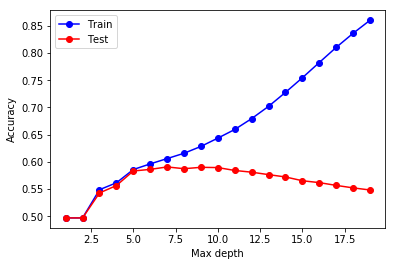

In [115]:
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

In [116]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [117]:
clf.fit(X_train, y_train)
# tree_importance = clf.feature_importances_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

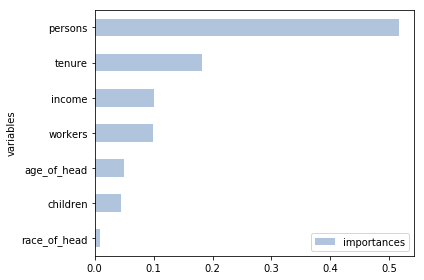

In [118]:
aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()


In [119]:
pd.crosstab( y_test.cars_alt, clf.predict(X_test), normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.224144,0.535961,0.192114,0.047781
1,0.033347,0.628202,0.292679,0.045772
2,0.003101,0.149735,0.747225,0.099940
3,0.001783,0.050780,0.477248,0.470188


In [120]:
clf.score(X_test, y_test)

0.6012145748987854

## Random Forest

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
clf = RandomForestClassifier(n_estimators=100,criterion='entropy',max_depth=5)
scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
scores

{'fit_time': array([78.75218916, 76.88757825, 79.99825883]),
 'score_time': array([4.74883509, 4.70474243, 4.69060802]),
 'test_score': array([0.61092496, 0.58981243, 0.55823212]),
 'train_score': array([0.57861722, 0.58653409, 0.60453241])}

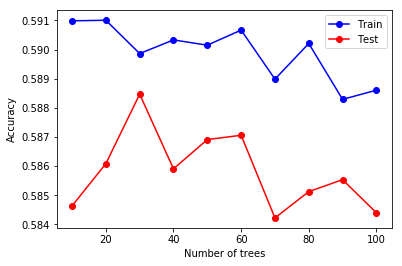

In [125]:
result_train_rf = []
result_test_rf = []
tree_num = range(10,102,10)
for i in tree_num:
    clf = RandomForestClassifier(n_estimators=i,criterion='entropy',max_depth=5)
    scores = cross_validate(clf, X_train, y_train.cars_alt, cv=3, return_train_score=True)
    result_train_rf.append(scores['train_score'].mean())
    result_test_rf.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(tree_num, result_train_rf, '-o',color='blue',label='Train')
plt.plot(tree_num, result_test_rf, '-o',color='red',label='Test')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()

<IPython.core.display.Javascript object>


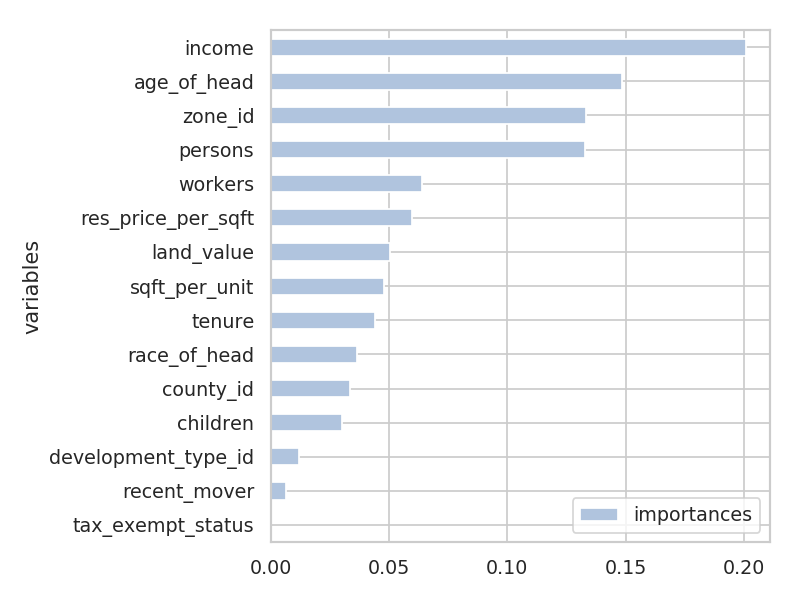

In [178]:
clf_rf = RandomForestClassifier(criterion='entropy',max_depth=30, n_estimators=50)
# scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
# print (scores)

clf_rf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf_rf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()


In [179]:
pd.crosstab( y_test, clf_rf.predict(X_test),normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.861206,0.113906,0.019540,0.005348
1,0.011591,0.945425,0.038812,0.004173
2,0.001643,0.040070,0.942567,0.015720
3,0.000787,0.016385,0.098023,0.884805


In [180]:
clf_rf.score(X_test, y_test)

0.9226607027788842

## Nueral network

In [ ]:
from sklearn.neural_network import MLPClassifier